In [ ]:
import pandas as pd

# Load the datasets
rating_csv = "/workspaces/codespaces-jupyter/data/rating.csv"
rating_df = pd.read_csv(rating_csv).sample(385, random_state=955)

movie_csv = "/workspaces/codespaces-jupyter/data/movie.csv"
movie_df = pd.read_csv(movie_csv)

# Merge the datasets
final_df = pd.merge(movie_df, rating_df, on='movieId', how='inner')

pd.set_option('display.max_columns', None)
df = final_df.drop(columns=['title', 'timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  600 non-null    int64  
 1   genres   600 non-null    object 
 2   userId   600 non-null    int64  
 3   rating   600 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 18.9+ KB


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert pipe-separated genres into space-separated strings
df['genres'] = df['genres'].str.replace('|', ' ', regex=False)

# TF-IDF transformation
tfidf = TfidfVectorizer()
tfidf_genres = tfidf.fit_transform(df['genres'])
tfidf_genres_df = pd.DataFrame(
    tfidf_genres.toarray(), 
    columns=[f"tfidf_{genre}" for genre in tfidf.get_feature_names_out()],
    index=df.index
)

# Drop and replace
df = df.drop(columns=['genres'])
df = pd.concat([df, tfidf_genres_df], axis=1)

# Target encoding: Replace userId/movieId with their average rating
user_means = df.groupby('userId')['rating'].mean()
movie_means = df.groupby('movieId')['rating'].mean()

df['userId_encoded'] = df['userId'].map(user_means)
df['movieId_encoded'] = df['movieId'].map(movie_means)

# Drop the original IDs
df = df.drop(columns=['userId', 'movieId'])

# Confirm the transformation
df[['userId_encoded', 'movieId_encoded']].describe()

,userId_encoded,movieId_encoded
count,600.000000,600.000000
mean,3.495000,3.495000
std,1.008921,0.960098
min,0.500000,0.500000
25%,3.000000,3.000000
50%,3.500000,3.500000
75%,4.000000,4.000000
max,5.000000,5.000000


In [3]:
import random
import numpy as np

# Store the target variable separately
y_full = df['rating']

# Create an imputation dataframe by dropping the dependent variable
imputation_df = df.drop('rating', axis=1)

# Set a random seed for reproducibility
random.seed(8)
np.random.seed(51)

# Calculate the total number of values in the dataframe
total_values = imputation_df.size

# Function to create a dataframe with a specified percentage of missing values
def create_missing_df(base_df, percent_missing):
    df_missing = base_df.copy()
    num_nulls = int(total_values * percent_missing)
    indices = [(row, col) for row in range(df_missing.shape[0]) for col in range(df_missing.shape[1])]
    random_indices = random.sample(indices, num_nulls)
    for row, col in random_indices:
        df_missing.iat[row, col] = np.nan
    return df_missing

# Create dataframes with different levels of missingness
df_5 = create_missing_df(imputation_df, 0.05)
df_10 = create_missing_df(imputation_df, 0.10)
df_15 = create_missing_df(imputation_df, 0.15)
df_20 = create_missing_df(imputation_df, 0.20)

# Display info for each dataframe
print("5% Missing Values:")
df_5.info()

print("\n10% Missing Values:")
df_10.info()

print("\n15% Missing Values:")
df_15.info()

print("\n20% Missing Values:")
df_20.info()

5% Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tfidf_action       563 non-null    float64
 1   tfidf_adventure    564 non-null    float64
 2   tfidf_animation    576 non-null    float64
 3   tfidf_children     572 non-null    float64
 4   tfidf_comedy       565 non-null    float64
 5   tfidf_crime        571 non-null    float64
 6   tfidf_documentary  571 non-null    float64
 7   tfidf_drama        577 non-null    float64
 8   tfidf_fantasy      580 non-null    float64
 9   tfidf_fi           569 non-null    float64
 10  tfidf_film         570 non-null    float64
 11  tfidf_horror       564 non-null    float64
 12  tfidf_imax         565 non-null    float64
 13  tfidf_musical      574 non-null    float64
 14  tfidf_mystery      575 non-null    float64
 15  tfidf_noir         565 non-null    float64
 16  tfidf_r

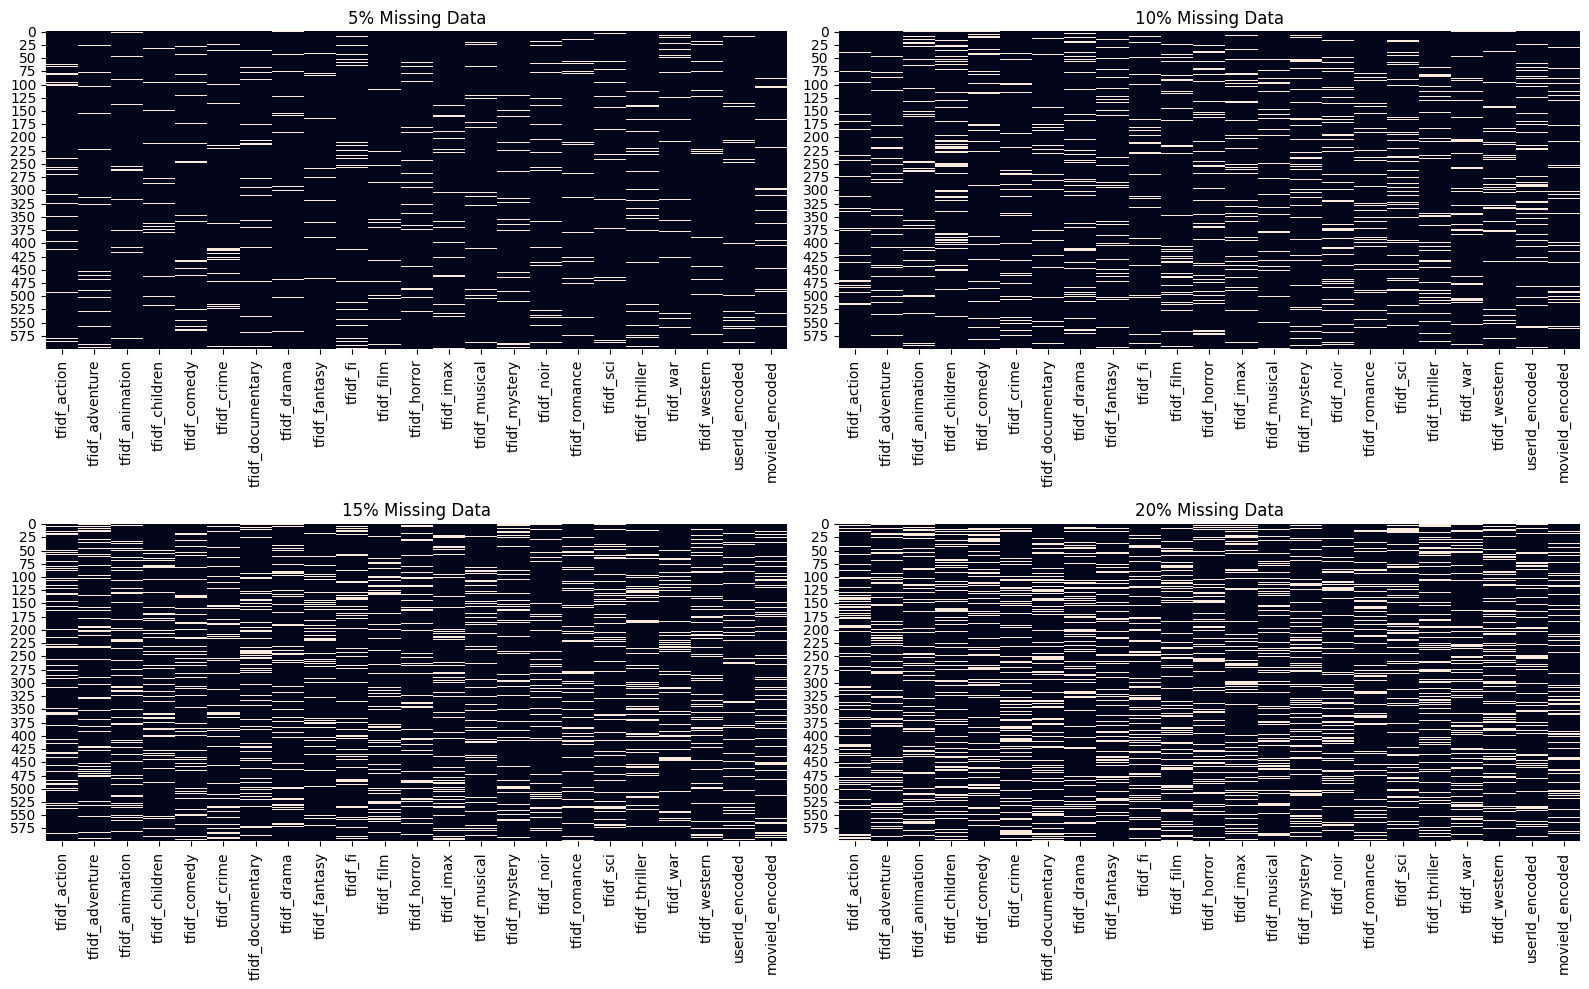

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid for the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot each heatmap
sns.heatmap(df_5.isnull(), cbar=False, ax=axes[0, 0])
axes[0, 0].set_title('5% Missing Data')

sns.heatmap(df_10.isnull(), cbar=False, ax=axes[0, 1])
axes[0, 1].set_title('10% Missing Data')

sns.heatmap(df_15.isnull(), cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('15% Missing Data')

sns.heatmap(df_20.isnull(), cbar=False, ax=axes[1, 1])
axes[1, 1].set_title('20% Missing Data')

# Improve layout
plt.tight_layout()
plt.show()

In [5]:
from sklearn.impute import SimpleImputer, KNNImputer
from fancyimpute import IterativeImputer  # for multivariate regression

# Put all missing dataframes into a dictionary for easier looping
missing_dfs = {
    '5%': df_5,
    '10%': df_10,
    '15%': df_15,
    '20%': df_20
}

# Store results
imputed_dfs = {}

for key, df in missing_dfs.items():
    print(f"\nProcessing {key} missing data...")

    # 1. Case-wise deletion
    imputed_dfs[f'{key}_casewise'] = df.dropna()

    # 2. Fill with 0
    imputed_dfs[f'{key}_zero'] = df.fillna(0)

    # 3. Fill with mean
    mean_imputer = SimpleImputer(strategy='mean')
    imputed_dfs[f'{key}_mean'] = pd.DataFrame(mean_imputer.fit_transform(df), columns=df.columns)

    # 4. KNN imputation (using 5 neighbors)
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_dfs[f'{key}_knn'] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

    # 5. Multivariate regression imputation (IterativeImputer is MICE-based)
    mice_imputer = IterativeImputer(random_state=42)
    imputed_dfs[f'{key}_regression'] = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns)

    print(f"Completed imputations for {key} missing data.")


Processing 5% missing data...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Completed imputations for 5% missing data.

Processing 10% missing data...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Completed imputations for 10% missing data.

Processing 15% missing data...


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Completed imputations for 15% missing data.

Processing 20% missing data...
Completed imputations for 20% missing data.


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
import os
import openai
import re
import ast

# Set your OpenAI API key
openai.api_key = os.environ.get("OPENAI_API_KEY") 

# Function to impute missing values using GPT
def impute_with_gpt(row, df_no_missing):
    if row.isnull().any():
        relevant_data = df_no_missing
        
        prompt = f"""You are a data analyst. Given the following dataset:\n\n{relevant_data.head(10).to_string(index=False)}\n\nPredict the missing values in this row and return ONLY a Python dictionary with the missing fields filled in:\n{row.to_dict()}"""

        if len(prompt.split()) > 1000:
            prompt = f"""You are a data analyst. Given a small sample of the dataset:\n\n{relevant_data.head(5).to_string(index=False)}\n\nPredict the missing values in this row and return ONLY a Python dictionary:\n{row.to_dict()}"""

        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful data assistant."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )

            completion = response['choices'][0]['message']['content']
            print("GPT response:\n", completion)

            # Extract dictionary using regex
            match = re.search(r"\{[\s\S]*?\}", completion)
            if match:
                dict_str = match.group(0)
                imputed_values = ast.literal_eval(dict_str)

                for col in row.index:
                    if pd.isnull(row[col]) and col in imputed_values:
                        row[col] = imputed_values[col]
            else:
                print("No dictionary found in GPT response.")

        except Exception as e:
            print("Error during GPT imputation:", e)

    return row

# Apply imputation
df_5_llm_imputed = df_5.apply(lambda row: impute_with_gpt(row, df_5.dropna()), axis=1)
df_10_llm_imputed = df_10.apply(lambda row: impute_with_gpt(row, df_10.dropna()), axis=1)
df_15_llm_imputed = df_15.apply(lambda row: impute_with_gpt(row, df_15.dropna()), axis=1)
df_20_llm_imputed = df_20.apply(lambda row: impute_with_gpt(row, df_20.dropna()), axis=1)

imputed_dfs['5%_llm'] = df_5_llm_imputed
imputed_dfs['10%_llm'] = df_10_llm_imputed
imputed_dfs['15%_llm'] = df_15_llm_imputed
imputed_dfs['20%_llm'] = df_20_llm_imputed

GPT response:
 To predict the missing value for `'tfidf_drama'`, we can analyze the existing dataset to find patterns or averages that might help us fill in the missing value. Given the dataset, we can calculate the average `'tfidf_drama'` value for rows with similar characteristics, such as the same `'userId_encoded'` and `'movieId_encoded'`.

Let's calculate the average `'tfidf_drama'` for rows where `'userId_encoded'` is 4.0 and `'movieId_encoded'` is 4.0:

1. Row 1: `'tfidf_drama'` = 0.0
2. Row 3: `'tfidf_drama'` = 0.0
3. Row 4: `'tfidf_drama'` = 0.0
4. Row 7: `'tfidf_drama'` = 0.441849

Average `'tfidf_drama'` = (0.0 + 0.0 + 0.0 + 0.441849) / 4 = 0.11046225

Using this average, we can fill in the missing value for `'tfidf_drama'` in the given row.

Here is the Python dictionary with the missing field filled in:

```python
{
    'tfidf_action': 0.0,
    'tfidf_adventure': 0.4635840148867947,
    'tfidf_animation': 0.0,
    'tfidf_children': 0.6578147253707054,
    'tfidf_comedy': 0

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Store results
regression_results = {}

# Loop through each imputed DataFrame
for name, imputed_df in imputed_dfs.items():
    # Copy the features
    X = imputed_df.copy()

    # Reindex the target variable to match X's index
    y = y_full.reindex(X.index)

    # Drop any rows where y is NaN (can happen after case-wise deletion)
    valid_idx = y.notnull()
    X = X[valid_idx].dropna()
    y = y.loc[X.index]

    # Define cross-validator
    kf = KFold(n_splits=3, shuffle=True, random_state=7)

    # Fit and predict with cross-validation
    model = RandomForestRegressor(n_estimators=100, random_state=72)
    y_pred = cross_val_predict(model, X, y, cv=kf)

    # Evaluate
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    # Store metrics
    regression_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# Display results
results_5 = {method: results for method, results in regression_results.items() if method.startswith('5%')}
results_10 = {method: results for method, results in regression_results.items() if method.startswith('10%')}
results_15 = {method: results for method, results in regression_results.items() if method.startswith('15%')}
results_20 = {method: results for method, results in regression_results.items() if method.startswith('20%')}

# Convert the dictionaries into DataFrames
df_5_results = pd.DataFrame(results_5).T
df_10_results = pd.DataFrame(results_10).T
df_15_results = pd.DataFrame(results_15).T
df_20_results = pd.DataFrame(results_20).T

# Display the results
print("\nRegression Results for 5% Missing Data:")
print(df_5_results[['MAE', 'MSE', 'RMSE']].round(4))

print("\nRegression Results for 10% Missing Data:")
print(df_10_results[['MAE', 'MSE', 'RMSE']].round(4))

print("\nRegression Results for 15% Missing Data:")
print(df_15_results[['MAE', 'MSE', 'RMSE']].round(4))

print("\nRegression Results for 20% Missing Data:")
print(df_20_results[['MAE', 'MSE', 'RMSE']].round(4))


Regression Results for 5% Missing Data:
                  MAE     MSE    RMSE
5%_casewise    0.0369  0.0160  0.1266
5%_zero        0.0597  0.0417  0.2042
5%_mean        0.0548  0.0342  0.1851
5%_knn         0.0622  0.0485  0.2203
5%_regression  0.0359  0.0230  0.1517
5%_llm         0.0702  0.0505  0.2247

Regression Results for 10% Missing Data:
                   MAE     MSE    RMSE
10%_casewise    0.1670  0.0894  0.2990
10%_zero        0.0914  0.0619  0.2488
10%_mean        0.0766  0.0445  0.2109
10%_knn         0.0891  0.0620  0.2489
10%_regression  0.0641  0.0485  0.2203
10%_llm         0.1364  0.1102  0.3320

Regression Results for 15% Missing Data:
                   MAE     MSE    RMSE
15%_casewise    0.2098  0.0800  0.2829
15%_zero        0.1051  0.1102  0.3320
15%_mean        0.0911  0.0769  0.2772
15%_knn         0.1281  0.1375  0.3708
15%_regression  0.0871  0.0844  0.2905
15%_llm         0.1306  0.0853  0.2920

Regression Results for 20% Missing Data:
                   MA